In [ ]:
## Load Library

In [2]:
%%capture
!pip install highdicom
!pip install wsidicom
!pip install idc-index --upgrade
!pip install openslide-python

In [3]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import json
import pandas as pd
import re


In [4]:
import os
import random
import subprocess
import pandas as pd
import numpy as np
import highdicom as hd
import matplotlib.pyplot as plt
from idc_index import index
from wsidicom import WsiDicom
from typing import List, Tuple, Union
import shapely
from shapely.geometry import Polygon, box
from shapely.strtree import STRtree
from PIL import Image, ImageDraw
from shapely.affinity import translate
from IPython.display import IFrame

In [5]:
print(os.getcwd())

/content


In [6]:
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/Capstone Code"
os.chdir(path)

Mounted at /content/gdrive


## 1. Filter the Patient we need from clinical data(bonus points)(skip first)

In [ ]:
# clinical = pd.read_json('./data/clinica_tcga_brca.json')

In [ ]:
# def extract_molecular_tests(follow_ups):
#     """Extract all molecular tests from follow_ups data."""
#     molecular_tests = []

#     # Handle case where follow_ups might be None or NaN
#     if follow_ups is None or (isinstance(follow_ups, float) and np.isnan(follow_ups)):
#         return molecular_tests

#     # Handle case where follow_ups is a list
#     if isinstance(follow_ups, list):
#         for follow_up in follow_ups:
#             # Handle dictionary case
#             if isinstance(follow_up, dict):
#                 if 'molecular_tests' in follow_up:
#                     molecular_tests.extend(follow_up['molecular_tests'])
#             # Handle list of dictionaries case
#             elif isinstance(follow_up, list):
#                 for entry in follow_up:
#                     if isinstance(entry, dict) and 'molecular_tests' in entry:
#                         molecular_tests.extend(entry['molecular_tests'])

#     # Handle case where follow_ups is a dictionary
#     elif isinstance(follow_ups, dict):
#         if 'molecular_tests' in follow_ups:
#             molecular_tests.extend(follow_ups['molecular_tests'])

#     return molecular_tests

# # Add the new column to the DataFrame
# clinical['molecular_tests'] = clinical['follow_ups'].apply(extract_molecular_tests)


In [ ]:
# def extract_gene_data(clinical_data):
#     """
#     Extracts gene symbols and test values from the 'molecular_tests' column of a clinical DataFrame.
#     Prioritizes 'test_value_range', then 'test_result' for test values.
#     """
#     extracted_data = []
#     for index, row in clinical_data.iterrows():
#         submitter_id = row['submitter_id']
#         molecular_tests = row['molecular_tests']

#         gene_data = {'submitter_id': submitter_id}

#         if isinstance(molecular_tests, list):
#             for test in molecular_tests:
#                 if isinstance(test, dict) and 'gene_symbol' in test:
#                     gene_symbol = test['gene_symbol']
#                     if gene_symbol not in gene_data or (gene_symbol in gene_data and pd.isna(gene_data[gene_symbol])):
#                         if 'test_value_range' in test:
#                             gene_data[gene_symbol] = test['test_value_range']
#                         elif 'test_result' in test:
#                             if test['test_result'].lower() == 'negative':
#                                 gene_data[gene_symbol] = 0
#                             elif test['test_result'].lower() == 'positive':
#                                 gene_data[gene_symbol] = np.nan
#                             else:
#                                 gene_data[gene_symbol] = np.nan # or handle other results as needed
#         extracted_data.append(gene_data)

#     return pd.DataFrame(extracted_data).fillna(np.nan)

# # Assuming 'clinical' is your DataFrame
# extracted_df = extract_gene_data(clinical)
# if 'Not Applicable' in extracted_df.columns:
#     extracted_df = extracted_df.drop(columns=['Not Applicable'])
# print(extracted_df.head())


In [ ]:
# filtered = extracted_df.dropna()
# filtered

## 2. Select the image ending with DX

In [ ]:
with open('./data/biospecimen_tcga_brca.json', 'r') as f:
    data = json.load(f)

slides_data = []

In [ ]:
for case in data:
    case_id = case.get("case_id")
    project_id = case.get("project", {}).get("project_id")
    submitter_id = case.get("submitter_id")

    for sample in case.get("samples", []):
        sample_id = sample.get("submitter_id")

        for portion in sample.get("portions", []):
            portion_id = portion.get("submitter_id")

            for slide in portion.get("slides", []):
                slides_data.append({
                    "case_id": case_id,
                    "project_id": project_id,
                    "submitter_id": submitter_id,
                    "sample_submitter_id": sample_id,
                    "portion_submitter_id": portion_id,
                    "slide_submitter_id": slide.get("submitter_id"),
                    "slide_id": slide.get("slide_id"),
                    "percent_tumor_cells": slide.get("percent_tumor_cells", "N/A"),
                    "percent_normal_cells": slide.get("percent_normal_cells", "N/A"),
                    "section_location": slide.get("section_location", "N/A")
                })


df = pd.DataFrame(slides_data)


print(df.head())


                                case_id project_id  submitter_id  \
0  001cef41-ff86-4d3f-a140-a647ac4b10a1  TCGA-BRCA  TCGA-E2-A1IU   
1  001cef41-ff86-4d3f-a140-a647ac4b10a1  TCGA-BRCA  TCGA-E2-A1IU   
2  001cef41-ff86-4d3f-a140-a647ac4b10a1  TCGA-BRCA  TCGA-E2-A1IU   
3  001cef41-ff86-4d3f-a140-a647ac4b10a1  TCGA-BRCA  TCGA-E2-A1IU   
4  001cef41-ff86-4d3f-a140-a647ac4b10a1  TCGA-BRCA  TCGA-E2-A1IU   

  sample_submitter_id portion_submitter_id       slide_submitter_id  \
0    TCGA-E2-A1IU-01Z                 None  TCGA-E2-A1IU-01Z-00-DX1   
1    TCGA-E2-A1IU-01A  TCGA-E2-A1IU-01A-11  TCGA-E2-A1IU-01A-01-TSA   
2    TCGA-E2-A1IU-11A  TCGA-E2-A1IU-11A-61  TCGA-E2-A1IU-11A-01-TSA   
3    TCGA-E2-A1IU-11A  TCGA-E2-A1IU-11A-61  TCGA-E2-A1IU-11A-03-TSC   
4    TCGA-E2-A1IU-11A  TCGA-E2-A1IU-11A-61  TCGA-E2-A1IU-11A-05-TSE   

                               slide_id percent_tumor_cells  \
0  47052187-fa15-40c7-a018-33576edf48e8                 N/A   
1  ba60c639-0f0b-4ccf-8990-d561c67794a

In [ ]:
# filtered_submitter_ids = filtered['submitter_id'].unique()
# filtered_image = df[df['submitter_id'].isin(filtered_submitter_ids)]
# filtered_image


In [ ]:
def check_slide_id(slide_id):
  """Checks if the slide_id ends with DX followed by a number."""
  match = re.search(r"DX\d+$", slide_id)
  return match is not None

In [ ]:
# # Find rows where slide_submitter_id does not end with DX(1,2,3,4...)
# # filtered_image = filtered_image[~filtered_image['slide_submitter_id'].apply(check_slide_id)]
# filtered_image = filtered_image[filtered_image['slide_submitter_id'].apply(check_slide_id)]

# filtered_image

In [ ]:
filtered_image = df[df['slide_submitter_id'].apply(check_slide_id)]

filtered_image

,case_id,project_id,submitter_id,sample_submitter_id,portion_submitter_id,slide_submitter_id,slide_id,percent_tumor_cells,percent_normal_cells,section_location
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-BRCA,TCGA-E2-A1IU,TCGA-E2-A1IU-01Z,None,TCGA-E2-A1IU-01Z-00-DX1,47052187-fa15-40c7-a018-33576edf48e8,N/A,N/A,Not Reported
8,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-BRCA,TCGA-A1-A0SB,TCGA-A1-A0SB-01Z,None,TCGA-A1-A0SB-01Z-00-DX1,92897823-9d08-495a-aa32-7e8822a57668,N/A,N/A,Not Reported
13,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-BRCA,TCGA-A2-A04W,TCGA-A2-A04W-01Z,None,TCGA-A2-A04W-01Z-00-DX1,d8bbff8f-d8d6-45a5-b21a-1c61d298bb9f,N/A,N/A,Not Reported
16,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-BRCA,TCGA-AN-A0AM,TCGA-AN-A0AM-01Z,None,TCGA-AN-A0AM-01Z-00-DX1,a21c7b61-d74e-42b1-991f-f6675ec33ccd,N/A,N/A,Not Reported
17,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-BRCA,TCGA-LL-A440,TCGA-LL-A440-01Z,None,TCGA-LL-A440-01Z-00-DX1,53e6ba94-ffc7-4af1-8aba-c12c3ae26830,N/A,N/A,Not Reported
...,...,...,...,...,...,...,...,...,...,...
3175,fe15c48b-116d-461e-9b40-68514730fd18,TCGA-BRCA,TCGA-A2-A0CP,TCGA-A2-A0CP-01Z,None,TCGA-A2-A0CP-01Z-00-DX1,6615bb50-fdf2-4695-b066-73778cb1b57c,N/A,N/A,Not Reported
3179,fe2cd610-aa52-4789-ac62-7683281bb22f,TCGA-BRCA,TCGA-PL-A8LX,TCGA-PL-A8LX-01A,None,TCGA-PL-A8LX-01A-02-DX2,1270d5aa-da5b-472e-9da4-c97488ee29b9,N/A,N/A,Not Reported
3180,fe7f74b8-20f4-4471-91dc-4cca8c68e5c0,TCGA-BRCA,TCGA-A2-A3XZ,TCGA-A2-A3XZ-01Z,None,TCGA-A2-A3XZ-01Z-00-DX1,048773d5-0220-4002-bb70-ae90e5405720,N/A,N/A,Not Reported
3182,fec0da58-1047-44d2-b6d1-c18cceed43dc,TCGA-BRCA,TCGA-E9-A295,TCGA-E9-A295-01Z,None,TCGA-E9-A295-01Z-00-DX1,bdcadd24-462b-48ce-9cf1-2e711277baee,N/A,N/A,Not Reported


In [ ]:
# filtered_image["submitter_id"].nunique()

517

## 3. Combine the filter image dataframe with the big query result

In [ ]:
idc_client = index.IDCClient() # set-up idc_client
idc_client.fetch_index('sm_instance_index')

In [ ]:
idc_client = index.IDCClient() # set-up idc_client
display(pd.DataFrame.from_dict(idc_client.indices_overview, orient='index')) # see available index tables

,description,installed,url,file_path
index,Main index containing one row per DICOM series.,True,None,/usr/local/lib/python3.11/dist-packages/idc_in...
prior_versions_index,index containing one row per DICOM series from...,True,None,/usr/local/lib/python3.11/dist-packages/idc_in...
sm_index,DICOM Slide Microscopy series-level index.,False,https://github.com/ImagingDataCommons/idc-inde...,None
sm_instance_index,DICOM Slide Microscopy instance-level index.,False,https://github.com/ImagingDataCommons/idc-inde...,None
clinical_index,Index of clinical data accompanying the availa...,False,https://github.com/ImagingDataCommons/idc-inde...,None


In [ ]:
idc_client.fetch_index('sm_index')
idc_client.fetch_index('sm_instance_index')
display(pd.DataFrame.from_dict(idc_client.indices_overview, orient='index'))

,description,installed,url,file_path
index,Main index containing one row per DICOM series.,True,None,/usr/local/lib/python3.11/dist-packages/idc_in...
prior_versions_index,index containing one row per DICOM series from...,True,None,/usr/local/lib/python3.11/dist-packages/idc_in...
sm_index,DICOM Slide Microscopy series-level index.,True,https://github.com/ImagingDataCommons/idc-inde...,/root/.local/share/idc_index_data/20.0.3/sm_in...
sm_instance_index,DICOM Slide Microscopy instance-level index.,True,https://github.com/ImagingDataCommons/idc-inde...,/root/.local/share/idc_index_data/20.0.3/sm_in...
clinical_index,Index of clinical data accompanying the availa...,False,https://github.com/ImagingDataCommons/idc-inde...,None


In [ ]:
print(f'Attributes in sm_index: \n{idc_client.sm_index.dtypes}\n')
print(f'Attributes in sm_instance_index: \n{idc_client.sm_instance_index.dtypes}')

Attributes in sm_index: 
SeriesInstanceUID                                              object
embeddingMedium_CodeMeaning                                    object
embeddingMedium_code_designator_value_str                      object
tissueFixative_CodeMeaning                                     object
tissueFixative_code_designator_value_str                       object
staining_usingSubstance_CodeMeaning                            object
staining_usingSubstance_code_designator_value_str              object
min_PixelSpacing_2sf                                          float64
max_TotalPixelMatrixColumns                                     Int64
max_TotalPixelMatrixRows                                        Int64
ObjectiveLensPower                                              Int64
primaryAnatomicStructure_code_designator_value_str             object
primaryAnatomicStructure_CodeMeaning                           object
primaryAnatomicStructureModifier_code_designator_value_str     ob

In [ ]:
display(idc_client.sm_index.head())

,SeriesInstanceUID,embeddingMedium_CodeMeaning,embeddingMedium_code_designator_value_str,tissueFixative_CodeMeaning,tissueFixative_code_designator_value_str,staining_usingSubstance_CodeMeaning,staining_usingSubstance_code_designator_value_str,min_PixelSpacing_2sf,max_TotalPixelMatrixColumns,max_TotalPixelMatrixRows,ObjectiveLensPower,primaryAnatomicStructure_code_designator_value_str,primaryAnatomicStructure_CodeMeaning,primaryAnatomicStructureModifier_code_designator_value_str,primaryAnatomicStructureModifier_CodeMeaning,illuminationType_code_designator_value_str,illuminationType_CodeMeaning,admittingDiagnosis_code_designator_value_str,admittingDiagnosis_CodeMeaning
0,1.3.6.1.4.1.5962.99.1.811505384.1597481443.172...,[Paraffin wax],[SCT:311731000],[Formalin],[SCT:431510009],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00026,157572,87969,40,SCT:363654007,Orbit,SCT:108369006,Tumor,DCM:111744,Brightfield illumination,ICDO3:8910/3,"Embryonal rhabdomyosarcoma, NOS"
1,1.3.6.1.4.1.5962.99.1.3134224716.1488492246.16...,[Tissue freezing medium],[SCT:433469005],[],[],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00025,97104,30635,40,SCT:68594002,Adrenal cortex,SCT:86049000,"Neoplasm, Primary",DCM:111744,Brightfield illumination,None,None
2,1.3.6.1.4.1.5962.99.1.1903462018.562844783.163...,[Tissue freezing medium],[SCT:433469005],[],[],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00025,89639,27063,40,SCT:28273000,Bile duct,SCT:86049000,"Neoplasm, Primary",DCM:111744,Brightfield illumination,None,None
3,1.3.6.1.4.1.5962.99.1.1216756412.40081724.1714...,[Paraffin wax],[SCT:311731000],[Formalin],[SCT:431510009],"[hematoxylin stain, water soluble eosin stain]","[SCT:12710003, SCT:36879007]",0.00025,31871,28141,40,SCT:14016003,Bone marrow,None,None,DCM:111744,Brightfield illumination,SCT:1162576007,Plasma cell myeloma
4,1.3.6.1.4.1.5962.99.1.863405578.828254310.1727...,[],[],[Tissue freezing medium],[SCT:433469005],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00026,104251,34038,40,SCT:83251001,Frontal lobe,SCT:108369006,Tumor,DCM:111744,Brightfield illumination,ICDO3:8000/3,"Neoplasm, malignant"


In [ ]:
print(idc_client.sm_index['primaryAnatomicStructureModifier_CodeMeaning'].unique())

['Tumor' 'Neoplasm, Primary' None 'Right' 'Soft tissue' 'Left' 'Normal'
 'Premalignant' 'Neoplasm, Metastatic' 'Posterior' 'Para-location'
 'Dorsal' 'Anterior' 'Recurrent tumor' 'Hyperplasia']


In [ ]:
print('\n'.join(set([val for item in idc_client.sm_index['embeddingMedium_CodeMeaning'] for val in item])))

Paraffin wax
Tissue freezing medium


In [ ]:
query = '''
SELECT
    index.PatientID,
    crdc_series_uuid,
    index.SeriesInstanceUID,
    index.StudyInstanceUID,
    index.collection_id,
    sm_index.primaryAnatomicStructureModifier_CodeMeaning
FROM
    index
JOIN
    sm_index ON sm_index.SeriesInstanceUID = index.SeriesInstanceUID
WHERE
    index.collection_id = 'tcga_brca'
ORDER BY index.SeriesInstanceUID
'''

example_slides_df = idc_client.sql_query(query)
selection = example_slides_df.iloc[[0,1,2]]

In [ ]:
example_slides_df.head(5)

,PatientID,crdc_series_uuid,SeriesInstanceUID,StudyInstanceUID,collection_id,primaryAnatomicStructureModifier_CodeMeaning
0,TCGA-D8-A145,84667a65-eeb9-4484-a657-f7956c677e99,1.3.6.1.4.1.5962.99.1.1200246273.1452585581.16...,2.25.206869084742869881275936265388611981590,tcga_brca,"Neoplasm, Primary"
1,TCGA-A2-A04T,82752524-56e1-43fe-a473-be3b889147c5,1.3.6.1.4.1.5962.99.1.1200260946.1445507284.16...,2.25.191602509018413470416126291380890693233,tcga_brca,"Neoplasm, Primary"
2,TCGA-BH-A0BT,50b4556b-42f8-4f37-a8f9-999c73ff6246,1.3.6.1.4.1.5962.99.1.1200315709.1964634771.16...,2.25.251415023068342653012691044774654943351,tcga_brca,"Neoplasm, Primary"
3,TCGA-E9-A1NF,4cc27a17-d978-4762-8168-45857456cadb,1.3.6.1.4.1.5962.99.1.1200348028.943225560.163...,2.25.291668355892196175685478881441324799429,tcga_brca,Normal
4,TCGA-BH-A0B7,072baf8a-ad77-4a86-aaac-11dce6fbde5e,1.3.6.1.4.1.5962.99.1.1200363002.1226588833.16...,2.25.151669791206361949031831562007554474390,tcga_brca,"Neoplasm, Primary"


In [ ]:
example_slides_df[example_slides_df["PatientID"] == "TCGA-A1-A0SB"]["SeriesInstanceUID"][2079]

'1.3.6.1.4.1.5962.99.1.1309093386.766508740.1637691665930.2.0'

## 4. Use gdc_manifest load the image

In [8]:
import sys
sys.path.append('.')

In [9]:
import sys

print("Python version")


print(sys.version)

Python version
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [13]:
!pip install openslide-bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 55.8 MB/s eta 0:00:00


In [14]:
# Import packages
import openslide
from tcga_utils import download_utils
from tcga_utils import wsi_utils
from matplotlib import pyplot as plt


import pandas as pd
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
df = download_utils.load_manifest_file('/content/gdrive/MyDrive/Capstone Code/data/gdc_manifest.txt')

In [ ]:
df.head(3)

,id,filename,md5,size,state
0,aa3f0051-ea7f-47f2-a7aa-315c1bdc3f18,TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFE...,8a43d85058bb6bc2fc00d485cf92e1c1,992971003,released
1,a779fff9-b54a-4c18-936f-43f75119b9ad,TCGA-EW-A1P1-01Z-00-DX1.4B670029-4B3B-4D76-8EA...,f90e7b66d9c64ebe9601ea5dbf48a709,1406597123,released
2,e5806a73-54c4-43d1-a44b-db5f43c8e832,TCGA-E9-A5FL-01Z-00-DX1.FB810D6A-303E-45DF-BEF...,974165ecf6416fbee667776e21e4e489,841538215,released


In [ ]:
wsi_file = download_utils.download_by_uuids('aa3f0051-ea7f-47f2-a7aa-315c1bdc3f18', save_direc = '/content/gdrive/MyDrive/Capstone Code/data/TCGA')
print(wsi_file)

/content/gdrive/MyDrive/Capstone Code/data/TCGA/TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFEF-7E96E994236A.svs


In [ ]:
wsi_file = '/content/gdrive/MyDrive/Capstone Code/data/TCGA/TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFEF-7E96E994236A.svs'
slide = wsi_utils.open_slide(wsi_file)

In [ ]:
slide = openslide.OpenSlide(wsi_file)

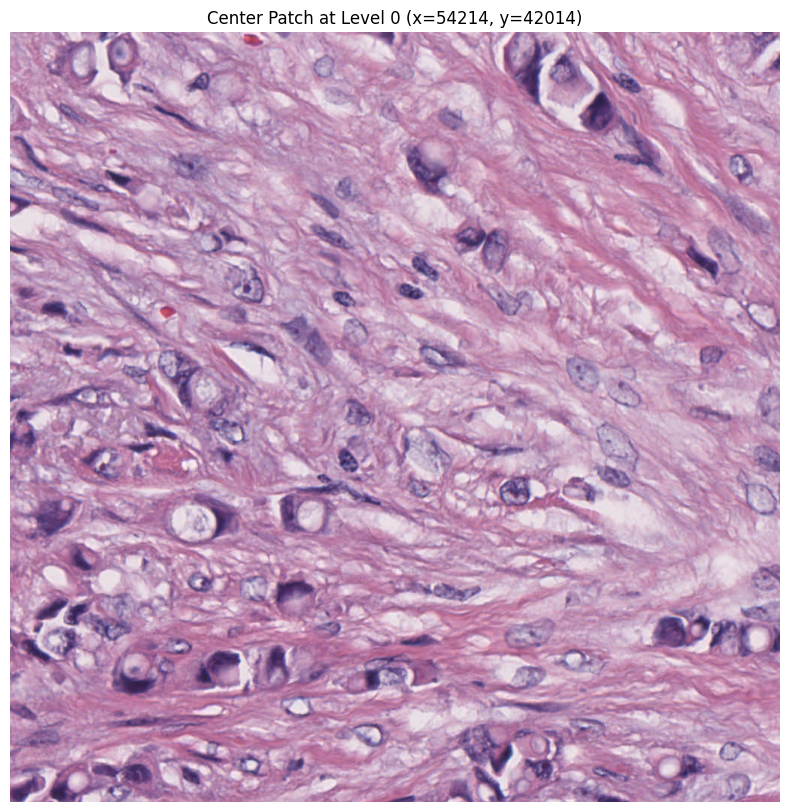

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 1. Display a thumbnail of the entire slide
# Most WSIs have a built-in thumbnail
if hasattr(slide, 'associated_images') and 'thumbnail' in slide.associated_images:
    thumb = slide.associated_images['thumbnail']
    plt.figure(figsize=(10, 8))
    plt.imshow(thumb)
    plt.axis('off')
    plt.title('Slide Thumbnail')
    plt.show()
else:
    # If no built-in thumbnail, get the lowest resolution level
    lowest_level = slide.level_count - 1
    thumb = slide.read_region((0, 0), lowest_level, slide.level_dimensions[lowest_level])
    plt.figure(figsize=(10, 8))
    plt.imshow(thumb)
    plt.axis('off')
    plt.title(f'Slide Overview (Level {lowest_level})')
    plt.show()

# 2. Display a specific region at higher resolution
# Extract a patch from the center of the slide at level 0 (highest resolution)
# width, height = slide.dimensions
# patch_size = 1024  # Size of the patch to extract
# x = width // 2 - patch_size // 2  # Center X
# y = height // 2 - patch_size // 2  # Center Y
# patch = slide.read_region((x, y), 0, (patch_size, patch_size))
# patch = patch.convert('RGB')  # Convert from RGBA to RGB

# plt.figure(figsize=(10, 10))
# plt.imshow(patch)
# plt.axis('off')
# plt.title(f'Center Patch at Level 0 (x={x}, y={y})')
# plt.show()

# # 3. Show multiple resolution levels
# fig, axes = plt.subplots(1, min(3, slide.level_count), figsize=(15, 5))
# if slide.level_count == 1:
#     axes = [axes]  # Make it iterable if there's only one level

# for i in range(min(3, slide.level_count)):
#     level_dim = slide.level_dimensions[i]
#     region = slide.read_region((0, 0), i, level_dim)
#     region = region.convert('RGB')

#     if slide.level_count > 1:
#         axes[i].imshow(region)
#         axes[i].set_title(f'Level {i} ({level_dim[0]}x{level_dim[1]})')
#         axes[i].axis('off')
#     else:
#         axes.imshow(region)
#         axes.set_title(f'Level {i} ({level_dim[0]}x{level_dim[1]})')
#         axes.axis('off')

# plt.tight_layout()
# plt.show()